# New libraries to install

In [ ]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC6'

# Import libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
import json

# Data generation or loading

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
device_filter = {
    'vendor':'Juniper',
    'role': 'PE'
}

In [ ]:
events_df = sands.generate_events_time_range(datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S'),datetime.strptime('10/01/22 00:00:01', '%m/%d/%y %H:%M:%S')+timedelta(days=10),parameters1,"none",device_filter)




In [ ]:
events_df.to_csv(join(path_files,'events_toxicity_analysis.csv'))

In [ ]:
inventory_df = sands.generate_device_inventory()

In [ ]:
events_df=pd.read_csv(join(path_files,'events_toxicity_analysis.csv'),index_col=0)

In [ ]:
events_df

,timestamp,event_name,source,fields
0,1664582401,warning: hardware fault,PE-1,"[{""device_name"": ""PE-1"", ""ip_address"": ""10.2.2..."
1,1664582401,warning: hardware fault,PE-7,"[{""device_name"": ""PE-7"", ""ip_address"": ""10.2.2..."
2,1664582401,warning: hardware fault,PE-14,"[{""device_name"": ""PE-14"", ""ip_address"": ""10.2...."
3,1664582401,warning: hardware fault,PE-35,"[{""device_name"": ""PE-35"", ""ip_address"": ""10.2...."
4,1664582401,warning: hardware fault,PE-41,"[{""device_name"": ""PE-41"", ""ip_address"": ""10.2...."
...,...,...,...,...
27116,1665446101,warning: hardware fault,PE-52,"[{""device_name"": ""PE-52"", ""ip_address"": ""10.2...."
27117,1665446101,warning: hardware fault,PE-53,"[{""device_name"": ""PE-53"", ""ip_address"": ""10.2...."
27118,1665446101,warning: hardware fault,PE-55,"[{""device_name"": ""PE-55"", ""ip_address"": ""10.2...."
27119,1665446101,warning: hardware fault,PE-59,"[{""device_name"": ""PE-59"", ""ip_address"": ""10.2...."


In [ ]:
inventory_df

,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,C-1,Juniper,PTX10000,Junos,21.3R1,hw3959392,core,10.2.1.1
1,C-2,Juniper,PTX10000,Junos,21.3R1,hw3959392,core,10.2.1.2
2,C-3,Juniper,PTX10000,Junos,21.3R1,hw3959392,core,10.2.1.3
3,C-4,Juniper,PTX10000,Junos,22.1R3,hw3959392,core,10.2.1.4
4,PE-1,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.1
...,...,...,...,...,...,...,...,...
299,E-98-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.98.2
300,E-99-1,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.1
301,E-99-2,Versa,versa_2,VOS,21.1.1,hw-versa-0001,vedge_branch,10.3.99.2
302,E-100-1,Versa,versa_2,VOS,21.1.0,hw-versa-0002,vedge_hub,10.3.100.1


In [ ]:
device_mask = np.logical_and(inventory_df['vendor']=='Juniper',inventory_df['role']=='PE')  

In [ ]:
events = events_df.copy()
entities = inventory_df[device_mask].copy()

# Data preparation

In [ ]:
MIN_SUPPORT = 0.01
MIN_CONFIDENCE = 10
MIN_LIFT = 4

In [ ]:
target_columns = ['version','hw_revision','vendor','model']

In [ ]:
all_items = set()
new_labels_column = []
for index,event in events.iterrows():
  event_labels = json.loads(event['fields'])[0]
  label_list = []
  label_keys = event_labels.keys()
  for label_key in label_keys:
    if (label_key in target_columns) and (not event_labels[label_key] == 'None'):
      new_item = label_key+':'+event_labels[label_key]
      label_list.append(new_item)
  new_labels_column.append(label_list) 
  all_items.update(label_list)
events['label_list']=new_labels_column

In [ ]:
events

,timestamp,event_name,source,fields,label_list
0,1664582401,warning: hardware fault,PE-1,"[{""device_name"": ""PE-1"", ""ip_address"": ""10.2.2...","[version:21.3R1, hw_revision:hw3958888, vendor..."
1,1664582401,warning: hardware fault,PE-7,"[{""device_name"": ""PE-7"", ""ip_address"": ""10.2.2...","[version:21.3R1, hw_revision:hw3958888, vendor..."
2,1664582401,warning: hardware fault,PE-14,"[{""device_name"": ""PE-14"", ""ip_address"": ""10.2....","[version:21.3R1, hw_revision:hw3958888, vendor..."
3,1664582401,warning: hardware fault,PE-35,"[{""device_name"": ""PE-35"", ""ip_address"": ""10.2....","[version:21.3R1, hw_revision:hw3958888, vendor..."
4,1664582401,warning: hardware fault,PE-41,"[{""device_name"": ""PE-41"", ""ip_address"": ""10.2....","[version:21.3R1, hw_revision:hw3958888, vendor..."
...,...,...,...,...,...
27116,1665446101,warning: hardware fault,PE-52,"[{""device_name"": ""PE-52"", ""ip_address"": ""10.2....","[version:22.1R3, hw_revision:hw3958888, vendor..."
27117,1665446101,warning: hardware fault,PE-53,"[{""device_name"": ""PE-53"", ""ip_address"": ""10.2....","[version:22.1R3, hw_revision:hw3958888, vendor..."
27118,1665446101,warning: hardware fault,PE-55,"[{""device_name"": ""PE-55"", ""ip_address"": ""10.2....","[version:22.1R3, hw_revision:hw3958890, vendor..."
27119,1665446101,warning: hardware fault,PE-59,"[{""device_name"": ""PE-59"", ""ip_address"": ""10.2....","[version:21.3R1, hw_revision:hw3958890, vendor..."


In [ ]:
len(all_items)

6

In [ ]:
events_basket = pd.DataFrame(np.zeros((events.shape[0],len(all_items))))
events_basket.columns = all_items

In [ ]:
for index,event in events.iterrows():
  label_list = event['label_list']
  events_basket.at[index,:]=0
  for label in label_list:
    events_basket.at[index,label]=1

In [ ]:
events_basket

,vendor:Juniper,hw_revision:hw3958890,version:21.3R1,hw_revision:hw3958888,model:MX960,version:22.1R3
0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,0.0,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,1.0,1.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...
27116,1.0,0.0,0.0,1.0,1.0,1.0
27117,1.0,0.0,0.0,1.0,1.0,1.0
27118,1.0,1.0,0.0,0.0,1.0,1.0
27119,1.0,1.0,1.0,0.0,1.0,0.0


# Frequent patterns calculation

In [ ]:
frequent_fp = fpgrowth(events_basket,min_support = MIN_SUPPORT,use_colnames=True)

/usr/local/lib/python3.8/dist-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
frequent_fp

,support,itemsets
0,1.000000,(model:MX960)
1,1.000000,(vendor:Juniper)
2,0.745658,(version:21.3R1)
3,0.663655,(hw_revision:hw3958888)
4,0.254342,(version:22.1R3)
5,0.336345,(hw_revision:hw3958890)
6,1.000000,"(vendor:Juniper, model:MX960)"
7,0.745658,"(version:21.3R1, vendor:Juniper)"
8,0.745658,"(version:21.3R1, model:MX960)"
9,0.745658,"(version:21.3R1, vendor:Juniper, model:MX960)"


In [ ]:
all_entity_items = set()
new_labels_column = []
label_types = entities.columns
for index,entity in entities.iterrows():
  label_values = entity.tolist()
  label_list = np.array([ltype+':'+lval for ltype,lval in zip(label_types,label_values)])
  not_none_mask = (entity != 'None')
  label_list = label_list[not_none_mask]
  new_labels_column.append(label_list)
  all_entity_items.update(label_list)
entities['label_list']=new_labels_column

In [ ]:
entities

,device_name,vendor,model,os,version,hw_revision,role,ip_address,label_list
4,PE-1,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.1,"[device_name:PE-1, vendor:Juniper, model:MX960..."
5,PE-2,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.2,"[device_name:PE-2, vendor:Juniper, model:MX960..."
6,PE-3,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.3,"[device_name:PE-3, vendor:Juniper, model:MX960..."
7,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,"[device_name:PE-4, vendor:Juniper, model:MX960..."
8,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,"[device_name:PE-5, vendor:Juniper, model:MX960..."
9,PE-6,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.6,"[device_name:PE-6, vendor:Juniper, model:MX960..."
10,PE-7,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.7,"[device_name:PE-7, vendor:Juniper, model:MX960..."
11,PE-8,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.8,"[device_name:PE-8, vendor:Juniper, model:MX960..."
12,PE-9,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.9,"[device_name:PE-9, vendor:Juniper, model:MX960..."
13,PE-10,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.10,"[device_name:PE-10, vendor:Juniper, model:MX96..."


In [ ]:
inventory_footprint = []
for index,itemset in frequent_fp.iterrows():
  items = set(itemset['itemsets'])
  #match_mask = items.issubset(good_entities['label_list'])
  match_mask = np.array([items.issubset(item) for item in entities['label_list']])
  num_instances = match_mask.sum()/entities.shape[0]
  inventory_footprint.append(num_instances)
frequent_fp['inventory_footprint']=inventory_footprint
frequent_fp['relative_toxicity']=frequent_fp['support']/frequent_fp['inventory_footprint']
frequent_fp['absolute_toxicity']=frequent_fp['support']

In [ ]:
size_list = []
for index, item in frequent_fp.iterrows():
  size_list.append(len(item['itemsets']))
frequent_fp['itemsets_size']=size_list 

In [ ]:
frequent_fp[:50]

,support,itemsets,inventory_footprint,relative_toxicity,absolute_toxicity,itemsets_size
0,1.000000,(model:MX960),1.000000,1.000000,1.000000,1
1,1.000000,(vendor:Juniper),1.000000,1.000000,1.000000,1
2,0.745658,(version:21.3R1),0.866667,0.860375,0.745658,1
3,0.663655,(hw_revision:hw3958888),0.900000,0.737395,0.663655,1
4,0.254342,(version:22.1R3),0.133333,1.907562,0.254342,1
5,0.336345,(hw_revision:hw3958890),0.100000,3.363445,0.336345,1
6,1.000000,"(vendor:Juniper, model:MX960)",1.000000,1.000000,1.000000,2
7,0.745658,"(version:21.3R1, vendor:Juniper)",0.866667,0.860375,0.745658,2
8,0.745658,"(version:21.3R1, model:MX960)",0.866667,0.860375,0.745658,2
9,0.745658,"(version:21.3R1, vendor:Juniper, model:MX960)",0.866667,0.860375,0.745658,3


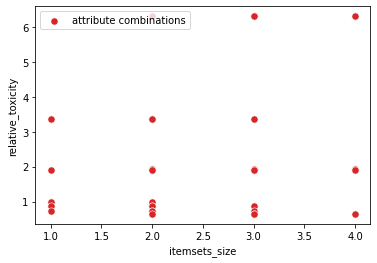

In [ ]:
sns.scatterplot(
      x= frequent_fp.itemsets_size,
      y= frequent_fp.relative_toxicity,
      color=sns.color_palette()[3],
      s=52,
      label='attribute combinations'
    )

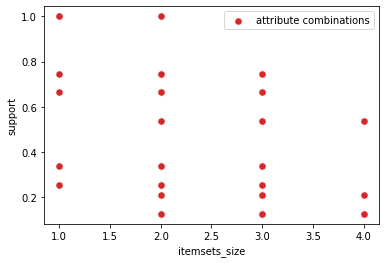

In [ ]:
sns.scatterplot(
      x= frequent_fp.itemsets_size,
      y= frequent_fp.support,
      color=sns.color_palette()[3],
      s=52,
      label='attribute combinations'
    )

# Final results

In [ ]:
RELATIVE_TOXICITY_THRESHOLD = 2.0
ABSOLUTE_TOXICITY_THRESHOLD = 0.1

In [ ]:
support_mask = frequent_fp['support'] > ABSOLUTE_TOXICITY_THRESHOLD
toxicity_mask = frequent_fp['relative_toxicity']>RELATIVE_TOXICITY_THRESHOLD
total_mask = np.logical_and(support_mask,toxicity_mask)

In [ ]:
frequent_fp['interest']='not interesting'
frequent_fp.loc[total_mask,'interest']='interesting'

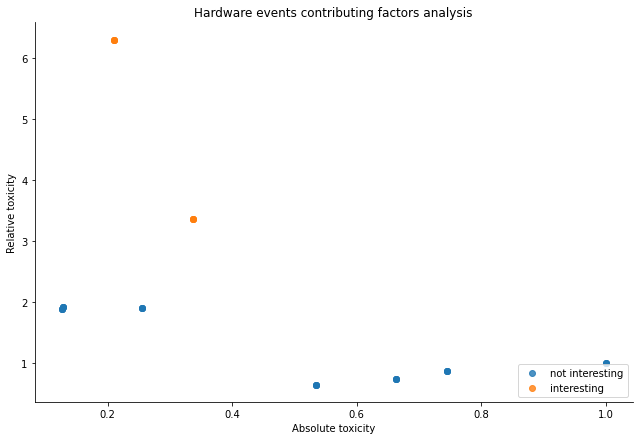

In [ ]:
sns.lmplot( x="support", y="relative_toxicity", data=frequent_fp, fit_reg=False, hue='interest', legend=False, height=6, aspect=1.5)
plt.legend(loc='lower right')
plt.xlabel('Absolute toxicity')
plt.ylabel('Relative toxicity')
plt.title('Hardware events contributing factors analysis')
plt.show()

In [ ]:
results = frequent_fp.loc[total_mask,['itemsets','support','relative_toxicity']]
results.columns = ['itemsets','absolute_toxicity','relative_toxicity']

In [ ]:
results

,itemsets,absolute_toxicity,relative_toxicity
5,(hw_revision:hw3958890),0.336345,3.363445
28,"(hw_revision:hw3958890, vendor:Juniper)",0.336345,3.363445
29,"(hw_revision:hw3958890, model:MX960)",0.336345,3.363445
30,"(hw_revision:hw3958890, version:21.3R1)",0.210280,6.308396
31,"(hw_revision:hw3958890, vendor:Juniper, model:...",0.336345,3.363445
32,"(hw_revision:hw3958890, version:21.3R1, vendor...",0.210280,6.308396
33,"(hw_revision:hw3958890, version:21.3R1, model:...",0.210280,6.308396
34,"(hw_revision:hw3958890, version:21.3R1, vendor...",0.210280,6.308396


In [ ]:
event_policy = sands.generate_event_policy(sands.generate_event_templates(),inventory_df,sands.generate_interface_inventory())

In [ ]:
event_policy[75:94]

,policy_name,event_id,period,probability,entity_table,entity_column,entity_name,fields
75,low hardware faults in PEs,5,minute,20,devices,device_name,PE-44,"[PE-44, 10.2.2.44, 21.3R1, hw3958888, PE, Juni..."
76,low hardware faults in PEs,5,minute,20,devices,device_name,PE-45,"[PE-45, 10.2.2.45, 21.3R1, hw3958888, PE, Juni..."
77,low hardware faults in PEs,5,minute,20,devices,device_name,PE-46,"[PE-46, 10.2.2.46, 21.3R1, hw3958888, PE, Juni..."
78,low hardware faults in PEs,5,minute,20,devices,device_name,PE-47,"[PE-47, 10.2.2.47, 21.3R1, hw3958888, PE, Juni..."
79,low hardware faults in PEs,5,minute,20,devices,device_name,PE-48,"[PE-48, 10.2.2.48, 21.3R1, hw3958888, PE, Juni..."
80,low hardware faults in PEs,5,minute,20,devices,device_name,PE-49,"[PE-49, 10.2.2.49, 21.3R1, hw3958888, PE, Juni..."
81,low hardware faults in PEs,5,minute,20,devices,device_name,PE-50,"[PE-50, 10.2.2.50, 21.3R1, hw3958888, PE, Juni..."
82,medium hardware faults in PEs,5,minute,40,devices,device_name,PE-51,"[PE-51, 10.2.2.51, 22.1R3, hw3958888, PE, Juni..."
83,medium hardware faults in PEs,5,minute,40,devices,device_name,PE-52,"[PE-52, 10.2.2.52, 22.1R3, hw3958888, PE, Juni..."
84,medium hardware faults in PEs,5,minute,40,devices,device_name,PE-53,"[PE-53, 10.2.2.53, 22.1R3, hw3958888, PE, Juni..."
